In [32]:
# imports
import pandas as p
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt


# constants
FOLDER_PATH = "../dataset/2019/"
FILE_NAME = 'cleaned_2019_01-03.csv'
SPEED_THRESHOLD = 0.3 # nautical knots
KNOTS_CONST = 1.943845249221964 # constant used to convert from m/s to nautical knots
EARTH_RADIUS_KM = 6378.137 # average value, used by geopy https://github.com/geopy/geopy/blob/master/geopy/distance.py
EARTH_RADIUS_M = 6378137

LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957

Import source csv into a dataframe

In [33]:
clean_df = p.read_csv(FOLDER_PATH + FILE_NAME)
print(f'Dataframe shape: {clean_df.shape}')
print(clean_df.columns)

Dataframe shape: (5415168, 17)
Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')


Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [34]:
def great_circle_distance_vectorized(lat_left, lon_left, lat_right, lon_right):
    '''Function used to calculate the Great-Circle distance between two GPS coordinates'''    
    lon_left, lat_left, lon_right, lat_right = map(np.radians, [lon_left, lat_left, lon_right, lat_right])
    deg_lon = lon_right - lon_left
    deg_lat = lat_right - lat_left
    a = np.sin(deg_lat/2.0)**2 + np.cos(lat_left) * np.cos(lat_right) * np.sin(deg_lon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = EARTH_RADIUS_M * c
    return meters

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# From the complete db, select only the necessary columns
clean_df = clean_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
                    'VesselName', 'VesselType', 'Status', 'Length',
                    'Width', 'Draft', 'TransceiverClass']].copy()
# Drop duplicates, just in case
clean_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)

# for each ship
for mmsi in p.unique(clean_df['MMSI']):
    # Extract all points generated by the ship
    appendDF = p.DataFrame(clean_df[clean_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = np.nan
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    appendDF['EstimatedStatus'] = np.nan
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.Name = mmsi
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points.
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the roght one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two point of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that hold the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = great_circle_distance_vectorized(pairsOfPointsDF['LAT_left'],
                                                        pairsOfPointsDF['LON_left'],
                                                        pairsOfPointsDF['LAT_right'],
                                                        pairsOfPointsDF['LON_right']
                                                        )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()
    # convert it into nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * KNOTS_CONST
    # round the final value to 2 decimal digits
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].copy()
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

print(V_s[-1])

           MMSI         BaseDateTime       LAT        LON   SOG    COG  \
0     248531000  2019-03-29 17:09:21  21.24056 -159.94390  11.7   89.1   
1     248531000  2019-03-29 17:45:42  21.24091 -159.81704  11.9   89.3   
2     248531000  2019-03-29 17:46:52  21.24094 -159.81297  11.8   90.2   
3     248531000  2019-03-29 17:56:41  21.24093 -159.77817  11.9   91.2   
4     248531000  2019-03-29 17:57:52  21.24091 -159.77396  12.0   90.8   
...         ...                  ...       ...        ...   ...    ...   
1171  248531000  2019-03-31 23:43:55  21.27792 -158.07253   0.2    3.5   
1172  248531000  2019-03-31 23:46:55  21.27793 -158.07252   0.2  174.6   
1173  248531000  2019-03-31 23:52:55  21.27793 -158.07252   0.2  198.0   
1174  248531000  2019-03-31 23:55:55  21.27793 -158.07254   0.1  182.1   
1175  248531000  2019-03-31 23:58:55  21.27790 -158.07253   0.1  181.1   

      Heading VesselName  VesselType  Status  Length  Width  Draft  \
0        86.0        NaN         NaN     

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

            MMSI         BaseDateTime       LAT        LON  SOG    COG  \
10640  338070127  2019-01-24 14:18:23  21.31309 -157.86718  0.0    0.0   
10641  338070127  2019-01-24 14:21:23  21.31310 -157.86716  0.0    0.0   
10642  338070127  2019-01-24 14:24:24  21.31310 -157.86717  0.0    0.0   
10643  338070127  2019-01-24 14:27:23  21.31309 -157.86714  0.9  142.5   
10644  338070127  2019-01-24 14:28:24  21.31215 -157.86705  8.2  174.5   
...          ...                  ...       ...        ...  ...    ...   
10780  338070127  2019-01-24 19:36:17  21.31311 -157.86716  0.0  141.1   
10781  338070127  2019-01-24 19:39:47  21.31312 -157.86716  0.0    1.4   
10782  338070127  2019-01-24 19:42:45  21.31312 -157.86716  0.0    0.0   
10783  338070127  2019-01-24 19:45:47  21.31312 -157.86717  0.0    0.0   
10784  338070127  2019-01-24 19:51:46  21.31312 -157.86715  0.0   31.7   

       Heading VesselName  VesselType  Status  Length  Width  Draft  \
10640    511.0   HONOLULU        50.0   

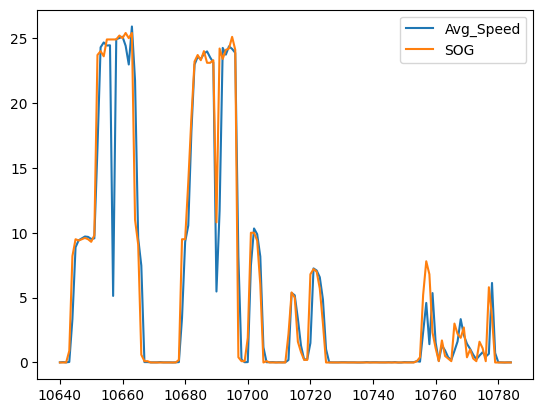

In [35]:
# for each vessel (dataframe) in the V_s list,

for shipDF in V_s:
    # set the status of each point where the avg_speed is lower than the given threshold, to 'stationary'
    shipDF['EstimatedStatus'] = np.where(shipDF["Avg_Speed"] < SPEED_THRESHOLD, 'stationary', shipDF['EstimatedStatus'])
    # set all remaining points as "sailing"
    shipDF['EstimatedStatus'] = np.where(shipDF["Avg_Speed"] >= SPEED_THRESHOLD, 'sailing', shipDF['EstimatedStatus'])
    # set the first 2 and last 2 points of each ship as "entry" and "exit" points respectively
    shipDF.loc[shipDF.index[0:2], 'EstimatedStatus'] = 'entry'
    shipDF.loc[shipDF.index[-2:], 'EstimatedStatus'] = 'exit'
    
# print a dataframe and some points just to check
interval = range(10640,10785)
print(V_s[3].iloc[interval])
plt.plot(V_s[3]['Avg_Speed'].iloc[interval])
plt.plot(V_s[3]['SOG'].iloc[interval])
plt.legend(['Avg_Speed', 'SOG'])


In [36]:
# Extract all the stationary points in a single dataframe

stationaryDF = p.DataFrame(columns=V_s[0].columns) # new empty df

for vesselDF in V_s:
    extractedDF = vesselDF[(vesselDF['EstimatedStatus'] == 'stationary') |
                           (vesselDF['EstimatedStatus'] == 'entry') |
                           (vesselDF['EstimatedStatus'] == 'exit')
                           ]
    stationaryDF = p.concat([stationaryDF, extractedDF], ignore_index=True)

print(stationaryDF)

print(f'{round((stationaryDF.shape[0]/clean_df.shape[0]) * 100, 2)}% of points are stationary!')

# delete 'clean_df' from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe
trash_list = [clean_df]
del clean_df
del trash_list 

# delete 'extractedDF' from RAM as it is no longer used
trash_list = [extractedDF]
del extractedDF
del trash_list

/tmp/ipykernel_8283/4223049045.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



              MMSI         BaseDateTime       LAT        LON  SOG    COG  \
0        338199855  2019-01-01 00:00:00  21.31309 -157.86712  0.0  360.0   
1        338199855  2019-01-01 00:01:09  21.31309 -157.86712  0.0  360.0   
2        338199855  2019-01-01 00:02:20  21.31309 -157.86712  0.0  360.0   
3        338199855  2019-01-01 00:03:31  21.31309 -157.86712  0.0  360.0   
4        338199855  2019-01-01 00:04:39  21.31308 -157.86712  0.0  360.0   
...            ...                  ...       ...        ...  ...    ...   
3754414  248531000  2019-03-31 23:43:55  21.27792 -158.07253  0.2    3.5   
3754415  248531000  2019-03-31 23:46:55  21.27793 -158.07252  0.2  174.6   
3754416  248531000  2019-03-31 23:52:55  21.27793 -158.07252  0.2  198.0   
3754417  248531000  2019-03-31 23:55:55  21.27793 -158.07254  0.1  182.1   
3754418  248531000  2019-03-31 23:58:55  21.27790 -158.07253  0.1  181.1   

         Heading  VesselName  VesselType  Status  Length  Width  Draft  \
0          51

In [37]:
# Some computationl tricks in order to save some time

# Round lat and lon values to 4 decimal digits (instead of 5)
stationaryDF = stationaryDF.round(decimals=4)
# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['MMSI','LAT', 'LON', 'EstimatedStatus']).size().reset_index(name='Weight')

# remove 'stationaryDF' from RAM as it is no longer used
trash_list = [stationaryDF]
del stationaryDF
del trash_list 


print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
groupedDF['Weight'].replace(0,1,inplace=True)

print(groupedDF)

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Pair with most occurrencies: 
MMSI                368926122
LAT                    21.297
LON                 -158.1065
EstimatedStatus    stationary
Weight                  61908
Name: 42809, dtype: object

            MMSI      LAT       LON EstimatedStatus  Weight
0         382872  21.3424 -157.9676      stationary     3.0
1         382872  21.3436 -157.9680      stationary     1.0
2         382872  21.3436 -157.9679      stationary     2.0
3         382872  21.3437 -157.9679      stationary     1.0
4         382872  21.3437 -157.9678      stationary     1.0
...          ...      ...       ...             ...     ...
51401  981000633  21.5830 -157.6137            exit     1.0
51402  981000633  21.5869 -157.6132            exit     1.0
51403  981000633  21.9472 -157.2075      stationary     1.0
51404  981000633  22.4373 -158.3419           entry     1.0
51405  981000633  22.4414 -158.3415           entry     1.0

[51406 rows x 5 columns]
Pair with most occurrencies: 
MMSI            

/tmp/ipykernel_8283/2180075439.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





DBSCAN(eps=0.1, min_samples=10) len: 51406, num of clusters: 51
            MMSI      LAT       LON EstimatedStatus  Weight  Label
0         382872  21.3424 -157.9676      stationary     3.0      0
1         382872  21.3436 -157.9680      stationary     1.0      0
2         382872  21.3436 -157.9679      stationary     2.0      0
3         382872  21.3437 -157.9679      stationary     1.0      0
4         382872  21.3437 -157.9678      stationary     1.0      0
...          ...      ...       ...             ...     ...    ...
51401  981000633  21.5830 -157.6137            exit     1.0     -1
51402  981000633  21.5869 -157.6132            exit     1.0     -1
51403  981000633  21.9472 -157.2075      stationary     1.0     -1
51404  981000633  22.4373 -158.3419           entry     1.0     -1
51405  981000633  22.4414 -158.3415           entry     1.0     -1

[51406 rows x 6 columns]


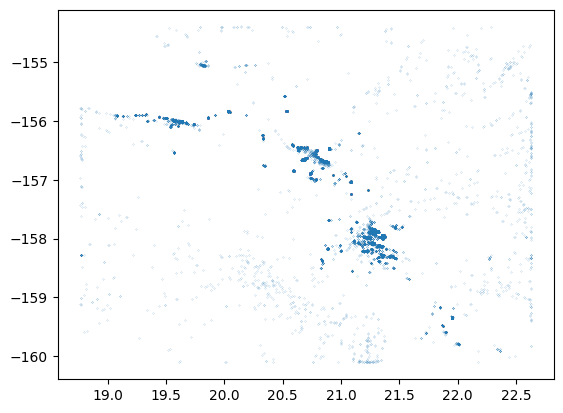

In [38]:
# import garbage collector in order to free some RAM before
# the execution of DBSCAN (this implementation has a O(n^2) space cost)

import gc
gc.collect()


# Run DBSCAN algorithm on the stationary points

# this scatter plot gives a rough idea of how the point should look like plotted on a map
plt.scatter(groupedDF.iloc[:,1], groupedDF.iloc[:,2], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.10, min_samples=10)

estimator = dbscan.fit(
                    X=groupedDF.iloc[:, 1:3], 
                    sample_weight=groupedDF['Weight']
                    )


print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

print(groupedDF)

In [39]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()

outliersDF = groupedDF[groupedDF['Label'] == -1].copy()

# plot clustered points on a map
fig = px.scatter_mapbox(data_frame = clusteredPointsDF,
                        lon = clusteredPointsDF['LON'],
                        lat= clusteredPointsDF['LAT'],
                        zoom = 6,
                        color = clusteredPointsDF['Label'],
                        title = 'Clustered stationary points. Eps: ' + str(estimator.get_params()['eps']) + ', min_size: ' + str(estimator.get_params()['min_samples']),
                        color_continuous_scale='portland',  #portland
                        hover_data=['MMSI', 'EstimatedStatus']
                        )

# add unclustered points
fig.add_scattermapbox(
                      lat= outliersDF['LAT'],
                      lon= outliersDF['LON'],
                      below=0,
                      marker={'color':'white'},
                      hovertext=outliersDF[['MMSI','EstimatedStatus']]
                      )

# add domain border
fig.add_trace(go.Scattermapbox(
                                mode = 'lines',
                                lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                marker = {'size':10,
                                          'color': 'red'}
                                ))

fig.update_layout(mapbox_style = 'open-street-map',
                  margin={'r':0, 't':40, 'l':0, 'b':0},

                  )


po.plot(fig)


'temp-plot.html'